## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [5]:
v_model = 'vsc'
# v_model = 'mae'


In [6]:
!pwd

/home/esslab/AI_projects/yunghui/mae/demo


In [7]:
import sys
import os
import requests
from pathlib import Path

import torch
import numpy as np
from torchinfo import summary
import torchvision.transforms as transforms

from  torchvision.transforms import InterpolationMode
import torchvision.utils as vutils

import matplotlib.pyplot as plt
from PIL import Image


# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae_vsc
import models_mae
from util.datasets import ImageDatasetFromFile

### Define utils

In [8]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    if v_model == 'vsc':
        model = getattr(models_mae_vsc, arch)()
    else:
        model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    if v_model == 'vsc':
        *loss, y, mask = model(x.float(), mask_ratio=0.75)
    else:
        loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

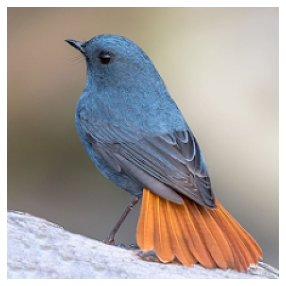

In [9]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_url = 'https://play-lh.googleusercontent.com/q1A3iAYUJI6wxOWI7iLvmjAx9rb53QiKUqB1wIfiPzkihWbYgqs_uuDrls45ayKqsUg=w240-h480-rw'

# img_url = 'https://www.calacademy.org/sites/default/files/styles/manual_crop_standard_960x540/public/assets/images/KW_IMAGES_DO_NOT_USE/atlas_moth_specimen_kevin_twomey-2.jpg?itok=TuoRQ36s&c=4874a7bbdf86685ab5d0739c7f1896c1'
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [9]:
# # This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# # download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

# chkpt_dir = 'mae_visualize_vit_large.pth'
# model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
# print('Model loaded.')


In [7]:
# chkpt_dir =  '../output_dir/checkpoint-1174.pth'
# model_mae= prepare_model(chkpt_dir, 'mae_vit_base_patch16')

### Run MAE on the image

In [177]:
ck = !ls -rt  ../output_dir | grep  -E  '^checkpoint-[0-9]{,4}\.pth'
ck

['checkpoint-1599.pth',
 'checkpoint-1174.pth',
 'checkpoint-97.pth',
 'checkpoint-0.pth']

'60'

In [48]:
ck = !ls -rt  ../output_dir | grep  -E  '^checkpoint-[0-9]{,3}\.pth'
print(ck)
ck = ck[-1]
print(f'loading {ck}')

# ck = 'VSC_A001_WR10_WP1e-2_W40_LRe-5_checkpoint-603_sample.pth'
chkpt_dir = f'../output_dir/{ck}'
v_model = 'vsc'
# v_model = 'mae'
model_mae_vsc = prepare_model(chkpt_dir, 'mae_vit_base_patch16')

alpha=0.01; weight_prior=1e-2; weight_rec=1.; lr=1.5e-5 
title = f'MAE_VSC (A{alpha}_Wp{str(weight_prior)}_Wr{weight_rec}_Lr{str(lr)})'
print(f'{title}')

['checkpoint-66.pth']
loading checkpoint-66.pth
<All keys matched successfully>
MAE_VSC (A0.01_Wp0.01_Wr1.0_Lr1.5e-05)


['checkpoint-65.pth']
loading checkpoint-65.pth
<All keys matched successfully>
MAE_VSC (A0.01_Wp1.0_Wr1.0_Lr1.5e-05)


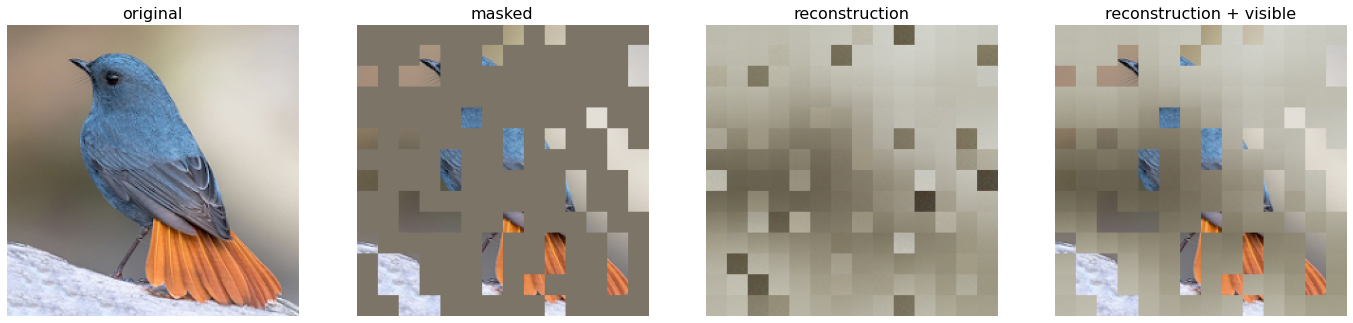

In [27]:
# make random mask reproduciblcve (comment out to make it change)
torch.manual_seed(2)


run_one_image(img, model_mae_vsc)

<All keys matched successfully>
MAE_VSC   (alpha 0.1_weight_prior 0.01_ weight_rec 10)_epoch63


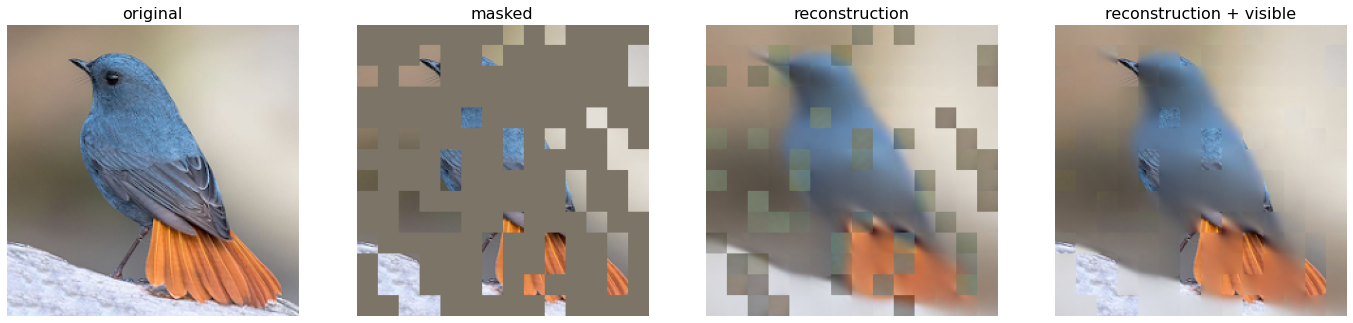

In [381]:
chkpt_dir = f'../output_dir/checkpoint-62_VSC_A01_WP_001.pth'
model_mae_vsc = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
torch.manual_seed(2)
alpha=0.1; weight_prior=0.01; weight_rec=10
title = f'MAE_VSC   (alpha {alpha}_weight_prior {weight_prior}_ weight_rec {weight_rec})'
print(f'{title}_epoch63')
run_one_image(img, model_mae_vsc)

<All keys matched successfully>
MAE with pixel reconstruction:


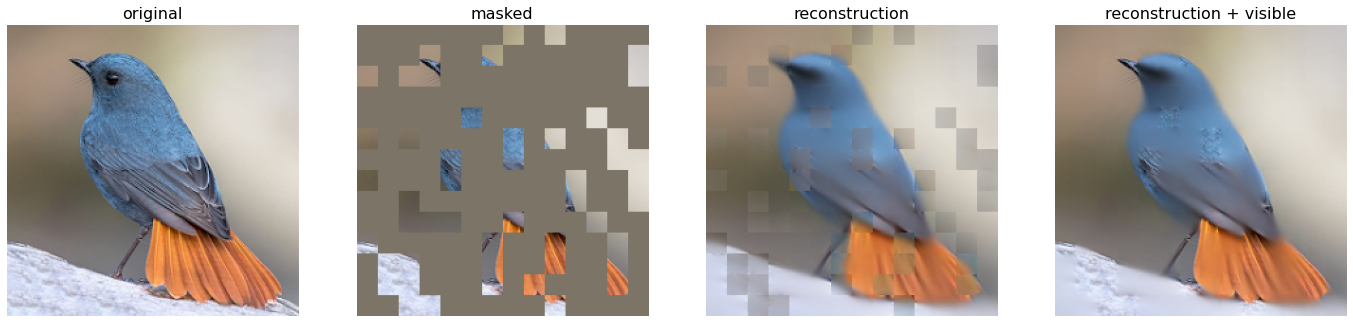

In [46]:
v_model = 'mae'
chkpt_dir = '../output_dir/ebird_pretrain_1174_NPOff_vit_base.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
# make random mask reproduciblcve (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [6]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


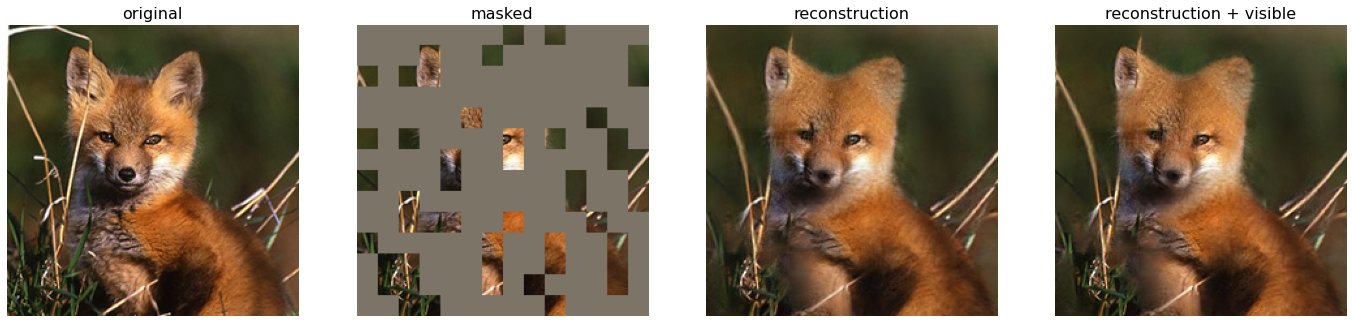

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

---

In [21]:

batch_size = 1

In [ ]:
v_model = 'mae'

chkpt_dir = '../output_dir/checkpoint-0-MAE.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
summary(model_mae, input_size=(batch_size, 3, 224, 224))

In [ ]:
# chkpt_dir = '../output_dir/checkpoint-0-MAE_VSC.pth'
# model_mae_vsc = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
batch_size=1
model_mae_vsc = getattr(models_mae_vsc, 'mae_vit_base_patch16')()
summary(model_mae_vsc, input_size=(batch_size, 3, 224, 224))

In [ ]:
# model_mae
==========================================================================================
Total params: 111,907,840
Trainable params: 111,655,680
Non-trainable params: 252,160
Total mult-adds (G): 90.73
==========================================================================================
Input size (MB): 240.84
Forward/backward pass size (MB): 46116.86
Params size (MB): 446.62
Estimated Total Size (MB): 46804.33
==========================================================================================

---

## Benchmark imgs Reconstruction

In [30]:
transform_val = transforms.Compose([
        transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop((224,224)),
        # transforms.RandomResizedCrop(args.input_size, scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
dir_benchmarks = Path('../benchmarks')
valid_list = [str(path) for path in dir_benchmarks.glob('*.jpg')]
# valid_set = ImageDatasetFromFile(valid_list, aug=False)
len(valid_list)

24

In [33]:
%%time
dataset_val = ImageDatasetFromFile(valid_list, transform=transform_val)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=len(dataset_val), shuffle=False, drop_last=False, pin_memory=True)
real = next(iter(data_loader_val))

CPU times: user 15.7 s, sys: 11.5 ms, total: 15.7 s
Wall time: 261 ms


In [52]:
ck = !ls -rt  ../output_dir | grep  -E  '^checkpoint-[0-9]{,3}\.pth'
print(ck)
ck = ck[-1]
print(f'loading {ck}')

# ck = 'VSC_A001_WR10_WP1e-2_W40_LRe-5_checkpoint-603_sample.pth'
chkpt_dir = f'../output_dir/{ck}'
v_model = 'vsc'
# v_model = 'mae'
model_mae_vsc = prepare_model(chkpt_dir, 'mae_vit_base_patch16')

alpha=0.01; weight_prior=1e-2; weight_rec=1.; lr=1.5e-5 
title = f'MAE_VSC (A{alpha}_Wp{str(weight_prior)}_Wr{weight_rec}_Lr{str(lr)})'
print(f'{title}')

['checkpoint-82.pth']
loading checkpoint-82.pth
<All keys matched successfully>
MAE_VSC (A0.01_Wp0.01_Wr1.0_Lr1.5e-05)


In [53]:
%%time
torch.manual_seed(0)
model = model_mae_vsc
model.eval
with torch.no_grad():
    *loss, y, mask = model(real, mask_ratio=0.75)
    rec= model.unpatchify(y)
    rec = rec.detach().cpu()

CPU times: user 1min 53s, sys: 4.09 s, total: 1min 58s
Wall time: 2.01 s


In [54]:
%%time
epoch_ =  ck.split('checkpoint-')[-1].split('.pth')[0]
bm_title = f'Benchmarks_Rec_{title}_{epoch_}'
root = Path('.')
save_path = f'{root}/{bm_title}.jpg'
nrow=8
images_stack = torch.cat([real, rec], dim=0)
vutils.save_image(images_stack.data.cpu(), save_path, nrow=nrow,  title=bm_title)

CPU times: user 1.09 s, sys: 189 ms, total: 1.28 s
Wall time: 60.2 ms


In [4]:
    elif flag == 'valid':
        images_stack = torch.cat([real, rec], dim=0)
        save_path = outf.joinpath(
            'vsc_valid', f'benchmarks_epoch_{epoch:05d}.jpg')

    images_stack = torchvision.transforms.Resize(
        resize)(images_stack) if resize else images_stack

    if save:
        vutils.save_image(images_stack.data.cpu(), save_path, nrow=nrow)

SyntaxError: invalid syntax (3953673828.py, line 1)

In [ ]:
x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

# run MAE
if v_model == 'vsc':
    *loss, y, mask = model(x.float(), mask_ratio=0.75)
else:
    loss, y, mask = model(x.float(), mask_ratio=0.75)
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()


